<a href="https://colab.research.google.com/github/theovercomer8/captionr/blob/main/TO8_Captionr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Captionr by theovercomer8
You can find the latest update to the notebook [here](https://github.com/theovercomer8/captionr).

v. 0.3.0

Changelog:

* 2/27/23: Added fuzz_ratio for similarity matching
* 2/15/23: Added Caption Editor widget
* 2/12/23: Added BLIP2 questions
* 2/11/23: Added BLIP2 support
* 2/11/23: Added GDrive cell
* 2/11/23: Refactored to support new captionr.py module


In [ ]:
#@title GDrive
mount_drive = True #@param {type: 'boolean'}
if mount_drive:
  from google.colab import drive
  drive.mount('/content/gdrive')

In [ ]:
#@title Install Dependencies
#@markdown Installs requirements and imports CLIP data
import os

if not os.path.exists('/content/dataset'):
  !mkdir /content/dataset
%cd /content
!git clone https://github.com/theovercomer8/captionr
%cd /content/captionr
!pip install -r requirements.txt
!apt-get install aria2
!pip install prettytable



In [ ]:
#@title Login to Huggingface hub
from huggingface_hub import login
%store -r

#@markdown Login to Huggingface hub
#@markdown 1. You need a Huggingface account.
#@markdown 2. To create a huggingface token, go to https://huggingface.co/settings/tokens, then create a new token or copy an available token with the `Write` role.
write_token = "" #@param {type:"string"}
login(write_token, add_to_git_credential=True)

%store write_token


In [ ]:
#@title Download and Extract Zip (.zip)
import os
import shutil
from pathlib import Path
%store -r

root_dir = '/content'
#@markdown ### Define Zipfile URL or Zipfile Path
zipfile_url_or_path = "" #@param {'type': 'string'}
zipfile_dst = str(root_dir)+"/zip_file.zip"
extract_to = "/content/dataset" #@param {'type': 'string'}

if extract_to != "":
  os.makedirs(extract_to, exist_ok=True)
else:
  extract_to = "/content/dataset"

#@markdown This will ignore `extract_to` path and automatically extracting to `train_data_dir`
is_dataset = False 

#@markdown Tick this if you want to extract all files directly to `extract_to` folder, and automatically delete the zip to save disk space
auto_unzip_and_delete = False #@param{'type':'boolean'}

dirname = os.path.dirname(zipfile_dst)
basename = os.path.basename(zipfile_dst)

try:
  if zipfile_url_or_path.startswith("/content"):
    zipfile_dst = zipfile_url_or_path
    if auto_unzip_and_delete == False:
      if is_dataset:
        extract_to = "/content/dataset"
      !unzip -j {zipfile_dst} -d "{extract_to}"
  elif zipfile_url_or_path.startswith("https://drive.google.com"):
    !gdown --fuzzy  {zipfile_url_or_path}
  elif zipfile_url_or_path.startswith("magnet:?"):
    !aria2c --summary-interval=10 -c -x 10 -k 1M -s 10 {zipfile_url_or_path}
  elif zipfile_url_or_path.startswith("https://huggingface.co/"):
    if '/blob/' in zipfile_url_or_path:
      zipfile_url_or_path = zipfile_url_or_path.replace('/blob/', '/resolve/')

    hf_token = write_token
    user_header = f"\"Authorization: Bearer {hf_token}\""
    !aria2c --console-log-level=error --summary-interval=10 --header={user_header} -c -x 16 -k 1M -s 16 -d {dirname} -o {basename} {zipfile_url_or_path}
  else:
    !aria2c --console-log-level=error --summary-interval=10 -c -x 16 -k 1M -s 16 -d {dirname} -o {basename} {zipfile_url_or_path}

except Exception as e:
  print("An error occurred while downloading the file:", e)

if is_dataset:
  extract_to = '/content/dataset'

if auto_unzip_and_delete:
  !unzip -j {zipfile_dst} -d "{extract_to}"

  path_obj = Path(zipfile_dst)
  zipfile_name = path_obj.parts[-1]
  
  if os.path.isdir(zipfile_dst):
    print("\nThis zipfile doesn't exist or has been deleted \n")
  else:
    os.remove(zipfile_dst)
    print(f"\n{zipfile_name} has been deleted")

In [ ]:
#@title Caption Wizard
%cd /content/captionr

from captionr.captionr_class import Captionr, CaptionrConfig
from captionr.blip_cap import BLIP
from captionr.blip2_cap import BLIP2
from captionr.clip_interrogator import Interrogator, Config
from captionr.coca_cap import Coca
from captionr.git_cap import Git
import os
from PIL import Image
import pathlib
from tqdm import tqdm
from prettytable import PrettyTable
from IPython.core.display import display, HTML
import gc
import torch

#@markdown Folder to scan for images
folder_path = '/content/dataset' #@param {type:"string"}
#@markdown Folder to output captions. Captions will be named the same as the input image with the chosen extension. Leave `output_path` blank to output captions side-by-side
output_path = '' #@param {type:"string"}
folder = [pathlib.Path(folder_path)]
if output_path == '':
  output = folder[0]
else:
  output = pathlib.Path(output_path)

extension = 'txt' #@param ['txt','caption']
#@markdown Action to take for existing caption files
existing = 'ignore' #@param [ 'skip', 'ignore', 'copy', 'prepend', 'append']

#@markdown Read caption from filename if caption file does not exist
use_filename = False #@param {type:"boolean"}
#@markdown ---

#@markdown Max caption length
cap_length = 150 #@param {type: "slider", min: 0, max: 400}

#@markdown ---

git = False #@param {type:"boolean"}
coca = False #@param {type:"boolean"}
blip = False #@param {type:"boolean"}
#@markdown Will perform captioning in the priority set by `model_order` for any enabled models
model_order = 'coca,git,blip' #@param ['coca,git,blip','coca,blip,git','git,coca,blip','git,blip,coca','blip,coca,git','blip,git,coca']
#@markdown Phrases that will fail a caption pass and move to the fallback model. 
fail_phrases = 'a sign that says,writing that says,that says,with the word' #@param
#@markdown ---
#@markdown BLIP options (if BLIP enabled)
use_blip2 = False #@param {type:"boolean"}
#@markdown BLIP2 requires the Pro tier High-RAM shape to run. Any of the xl or larger models require a premium GPU.
blip2_model = 'blip2_opt/pretrain_opt2.7b' #@param ['blip2_t5/pretrain_flant5xxl','blip2_opt/pretrain_opt2.7b', 'blip2_opt/pretrain_opt6.7b', 'blip2_opt/caption_coco_opt2.7b', 'blip2_opt/caption_coco_opt6.7b', 'blip2_t5/pretrain_flant5xl', 'blip2_t5/caption_coco_flant5xl']
#@markdown Pipe `|` delimeted list of questions to ask BLIP2 and add answers as tags
blip2_questions = '' #@param {type: "string"}
#@markdown ---
blip_beams = 8 #@param {type: "slider", min: 1, max: 100}
blip_min = 30 #@param {type: "slider", min: 5, max: 75}
blip_max = 56 #@param {type: "slider", min: 5, max: 75}

#@markdown ---

clip_model_name = 'ViT-H-14/laion2b_s32b_b79k' #@param ['ViT-L-14/openai',"ViT-H-14/laion2b_s32b_b79k"]

#@markdown Use ViT-H for SD 2.x, ViT-L for SD 1.5
#@markdown
#@markdown Only used if one of the following flavor/artist/medium/movement/trending checkboxes are checked

clip_use_flavor = True #@param {type:"boolean"}
clip_max_flavors = 16 #@param {type: "slider", min: 1, max: 100}
clip_use_artist = False #@param {type:"boolean"}
clip_use_medium = False #@param {type:"boolean"}
clip_use_movement = False #@param {type:"boolean"}
clip_use_trending = False  #@param {type:"boolean"}
#@markdown Clip method to use
clip_method = 'interrogate_fast' #@param ['interrogate','interrogate_fast','interrogate_classic']
#@markdown ---
#@markdown Comma separated list of tags to ignore
ignore_tags = '' #@param {type:"string"}
#@markdown Find/replace in caption and tags. 
find = '' #@param {type:"string"}
replace = '' #@param {type:"string"}
#@markdown ---
#@markdown Tag the caption with the containing folder. Useful when using nested folder structure. Can tag up to `folder_tag_levels` deep
folder_tag = False #@param {type:"boolean"}
folder_tag_levels = 1 #@param {type: "slider", min: 1, max: 10}
#@markdown Do not tag folders any deeper than this path. Overrides `folder_tag_levels` if `folder_tag_stop` is shallower
folder_tag_stop = '' #@param {type:"string"}
#@markdown ---
#@markdown Ensure tag uniqueness if checked
uniquify_tags = True #@param {type:"boolean"}
#@markdown Similarity % allowed. Tags exceeding this percentage will be filtered.
fuzz_ratio = 60 #@param {type:"slider", min: 0, max: 100}
#@markdown Text to prepend or append to the generated caption. Useful for adding a subject or style
prepend_text = '' #@param {type:"string"}
append_text = '' #@param {type:"string"}
#@markdown Check `preview` to just perform a preview run without writing a caption file
preview = False #@param {type:"boolean"}
print_params = False #@param {type:"boolean"}
#@markdown ---


try:
  config
except NameError:
  config = CaptionrConfig()

try:
  last_blip2_model
except NameError:
  last_blip2_model = ''

config.folder = folder
config.output = output
config.existing = existing
config.cap_length = cap_length
config.git_pass = git
config.coca_pass = coca
config.blip_pass = blip
config.model_order = model_order
config.use_blip2 = use_blip2
config.blip2_model = blip2_model
config.blip2_questions = blip2_questions.split('|')
config.blip_beams = blip_beams
config.blip_min = blip_min
config.blip_max = blip_max
config.clip_model_name = clip_model_name
config.clip_flavor = clip_use_flavor
config.clip_artist = clip_use_artist
config.clip_medium = clip_use_medium
config.clip_movement = clip_use_movement
config.clip_trending = clip_use_trending
config.clip_method = clip_method
config.fuzz_ratio = fuzz_ratio
config.fail_phrases = fail_phrases
config.ignore_tags = ignore_tags
config.find = find
config.replace = replace
config.folder_tag = folder_tag
config.folder_tag_levels = folder_tag_levels
config.preview = preview
config.use_filename = use_filename
config.append_text = append_text
config.prepend_text = prepend_text
config.uniquify_tags = uniquify_tags
config.device = 'cuda'
config.extension = extension
config.quiet = True
config.base_path = '/content/captionr'



debug_params = ["folder", \
                "output", \
                "existing", \
                "cap_length", \
                "git_pass", \
                "coca_pass", \
                "blip_pass", \
                "model_order", \
                "use_blip2", \
                "blip2_model", \
                "blip2_questions", \
                "blip_beams", \
                "blip_min", \
                "blip_max", \
                "clip_model_name", \
                "clip_flavor", \
                "clip_artist", \
                "clip_medium", \
                "clip_medium", \
                "clip_movement", \
                "clip_trending", \
                "clip_method", \
                "fuzz_ratio", \
                "fail_phrases", \
                "ignore_tags", \
                "find", \
                "replace", \
                "folder_tag", \
                "folder_tag_levels", \
                "preview", \
                "use_filename", \
                "append_text", \
                "prepend_text", \
                "uniquify_tags", \
                "device", \
                "extension", \
                "quiet", \
                "debug", \
                "_git", \
                "_coca", \
                "_blip", \
                "_clip", \
                "base_path"]
if print_params:
  table = PrettyTable()
  table.field_names = ["Hyperparameter", "Value"]
  for params in debug_params:
      if params != "":
          if getattr(config,params) == "":
              value = "False"
          else:
              value = getattr(config,params)
          table.add_row([params, value])
  table.align = "l"
  print(table)

if folder_path == '':
  print ('Folder is required')
  exit()
  

if not config.git_pass \
      and not config.blip_pass \
      and not config.coca_pass \
      and not config.clip_flavor \
      and not config.clip_artist \
      and not config.clip_medium \
      and not config.clip_movement \
      and not config.clip_trending:
  if config.existing == 'skip' \
      and  ( \
          ( \
              config.find is not None and config.find != '' \
              and config.replace is not None and config.replace != '' \
          ) \
          or config.folder_tag \
          or ( \
              config.prepend_text is not None \
              and config.prepend_text != '' \
          ) \
          or ( \
              config.append_text is not None \
              and config.append_text != '' \
          ) \
      ):

      print ('existing=skip cannot be used for find/replace, folder tagging, text prepending/appending unless a caption model is selected. To run a caption pass without a model selected, please choose a different option for existing caption.')
      exit()
  else:
      if config.existing == 'skip' \
          and not ( \
              (config.find is not None and config.find != '' \
              and config.replace is not None and config.replace != '') \
              or config.folder_tag \
              or (config.prepend_text is not None \
                  and config.prepend_text != '') \
              or (config.append_text is not None \
                  and config.append_text != '') \
          ):

          print ('No captioning flags specified. Select a model or use CLIP tagging or use find/replace or use folder tagging or use append/prepend text to initiate captioning ')
          exit()

if config.coca_pass and config._coca is None:
    print("Loading Coca Model...")
    config._coca = Coca(config.device,max_length=config.cap_length)

if config.git_pass and config._git is None:
    print("Loading Git Model...")
    config._git = Git(config.device,max_length=config.cap_length)

if config.blip_pass and (config._blip is None or (config.blip2_model != last_blip2_model and config.use_blip2)):
    if config.use_blip2:
      if config.blip2_model != last_blip2_model:
        config._blip = None
        gc.collect()

        with torch.no_grad():
          torch.cuda.empty_cache()
      print("Loading BLIP2 Model...")
      config._blip = BLIP2(config.device,model_name=config.blip2_model,max_length=config.cap_length)
    else:
      print("Loading BLIP Model...")
      config._blip = BLIP(config.device,beams=config.blip_beams,blip_max=config.blip_max, blip_min=config.blip_min)

if config._clip == None and (config.clip_artist or config.clip_flavor or config.clip_medium or config.clip_movement or config.clip_trending):
    print("Loading Clip Model...")
    config._clip = Interrogator(Config(clip_model_name=config.clip_model_name,
                                        captionr_config=config,
                                        quiet=config.quiet,
                                        data_path=os.path.join(config.base_path,'data'),
                                        cache_path=os.path.join(config.base_path,'data')))
last_blip2_model = config.blip2_model

paths = []
cptr = Captionr(config=config)
for folder in config.folder:
    for root, dirs, files in os.walk(folder.absolute(), topdown=False):
        for name in files:
            if os.path.splitext(os.path.split(name)[1])[1].upper() not in ['.JPEG','.JPG','.JPE', '.PNG']:
                continue
            if config.extension not in os.path.splitext(os.path.split(name)[1])[1]:
                cap_file = os.path.join(folder.absolute(),os.path.splitext(os.path.split(name)[1])[0] + f'.{config.extension}')
            if not config.existing == 'skip' or not os.path.exists(cap_file):
                paths.append(os.path.join(root, name))
            else:
                print(f'Caption file {cap_file} exists. Skipping.')
for path in tqdm(paths):
    display(HTML(f'<div>-----</div><h1>{path}</h1>'))
    with Image.open(path).convert('RGB') as img:
      display(img.resize((200,200)))
    caption = cptr.process_img(path)
    display(HTML(f'<h2>Final Caption</h2><div>{caption}</div>'))




In [ ]:
import ipywidgets as widgets
from io import BytesIO
#@markdown #Edit Captions

#@markdown - Open a tool to view/edit captions.

paths=""
out=""
widgets_l=""
def Caption(path):
    name = os.path.splitext(os.path.basename(path))[0]
    ext=os.path.splitext(os.path.basename(path))[-1][1:]
    if ext=="jpg" or "JPG":
      ext="JPEG"      

    if os.path.exists(folder_path+"/"+name + '.' + extension):
      with open(folder_path+"/"+name + '.' + extension, 'r') as f:
          text = f.read()
    else:
      with open(folder_path+"/"+name + '.' + extension, 'w') as f:
          f.write("")
          with open(folder_path+"/"+name + '.' + extension, 'r') as f:
              text = f.read()   

    img=Image.open(os.path.join(folder_path,path))
    img=img.resize((420, 420))
    image_bytes = BytesIO()
    img.save(image_bytes, format=ext, qualiy=10)
    image_bytes.seek(0)
    image_data = image_bytes.read()
    img= image_data  
    image = widgets.Image(
        value=img,
        width=420,
        height=420
    )
    text_area = widgets.Textarea(value=text, description='', disabled=False, layout={'width': '300px', 'height': '120px'})
    

    def update_text(text):
        with open(folder_path+"/"+name + '.' + extension, 'w') as f:
            f.write(text)

    button = widgets.Button(description='Save', button_style='success')
    button.on_click(lambda b: update_text(text_area.value))

    return widgets.VBox([widgets.HBox([image, text_area, button])])


paths = os.listdir(folder_path)
paths = list(filter(lambda fn: not fn.endswith(extension), paths))

widgets_l = widgets.Select(options=["Select an image to caption"]+paths, rows=25)


out = widgets.Output()

def click(change):
    with out:
        out.clear_output()
        display(Caption(change.new))

widgets_l.observe(click, names='value')
display(widgets.HBox([widgets_l, out]))

In [ ]:
#@title Define your Huggingface Repo

from huggingface_hub import HfApi
from huggingface_hub.utils import validate_repo_id, HfHubHTTPError
%store -r

api = HfApi()
user = api.whoami(write_token)

#@markdown #### If your model/dataset repo doesn't exist, it will automatically create your repo.
dataset_name = "" #@param{type:"string"}
make_this_dataset_private = True #@param{type:"boolean"}

datasets_repo = user['name']+"/"+dataset_name.strip()

if dataset_name != "":
  try:
      validate_repo_id(datasets_repo)
      api.create_repo(repo_id=datasets_repo,
                      repo_type="dataset",
                      private=make_this_dataset_private)
      print("Dataset Repo didn't exists, creating repo")
      print("Dataset Repo",datasets_repo,"created!\n")

  except HfHubHTTPError as e:
      print(f"Dataset repo: {datasets_repo} exists, skipping create repo\n")


Dataset repo: theovercomer8/to8highkey exists, skipping create repo



In [ ]:
#@title Upload Dataset
from huggingface_hub import HfApi
from pathlib import Path
import shutil
import zipfile
import os

api = HfApi()

#@markdown #### This will be compressed to zip and  uploaded to datasets repo, leave it empty if not necessary
dataset_path = "/content/dataset" #@param {type :"string"}
dataset_name = "dataset" #@param {type :"string"}
#@markdown #### Delete zip after upload
delete_zip = True #@param {type :"boolean"}

tmp_dataset = "/content/dataset"

dataset_zip = f"/content/{dataset_name}.zip"


#@markdown #### Other Information
commit_message = "" #@param {type :"string"}

if not commit_message:
  commit_message = "feat: upload captioned dataset"

def upload_dataset(dataset_paths, is_zip : bool):
  path_obj = Path(dataset_paths)
  dataset_name = path_obj.parts[-1]

  if is_zip:
    print(f"Uploading dataset to https://huggingface.co/datasets/"+datasets_repo)
    print(f"Please wait...")

    api.upload_file(
        path_or_fileobj=dataset_paths,
        path_in_repo=dataset_name,
        repo_id=datasets_repo,
        repo_type="dataset",
        commit_message=commit_message,
    )
    print(f"Upload success, located at https://huggingface.co/datasets/"+datasets_repo+"/blob/main/"+dataset_name+"\n")
  else:
    print(f"Uploading {dataset_name} to https://huggingface.co/datasets/"+datasets_repo)
    print(f"Please wait...")

    api.upload_folder(
        folder_path=dataset_paths,
        path_in_repo=dataset_name,
        repo_id=datasets_repo,
        repo_type="dataset",
        commit_message=commit_message,
        ignore_patterns=".ipynb_checkpoints",
    )
    print(f"Upload success, located at https://huggingface.co/datasets/"+datasets_repo+"/tree/main/"+dataset_name+"\n")
  
def zip_file(tmp,zip):
    zipfiles = zip 
    with zipfile.ZipFile(zipfiles, 'w') as zip:
      for tmp, dirs, files in os.walk(tmp):
          for file in files:
              zip.write(os.path.join(tmp, file))

def upload():
  zip_file(tmp_dataset,dataset_zip)
  upload_dataset(dataset_zip, True)
  if delete_zip:
    os.remove(dataset_zip)

upload()




<a href="https://ko-fi.com/theovercomer8" target="_blank">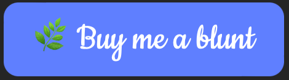</a>